In [5]:
%matplotlib inline
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from typing import Dict, List, Union
from IPython.display import Image, display


In [2]:
# Dictionary mapping model names to their checkpoint paths
BEST_MODELS: Dict[str, Path] = {
    "yolov12n": Path("runs/yolov12/nano/final_v12_nano/weights/best.pt"),
    "yolov12s": Path("runs/yolov12/small/final_v12_small/weights/best.pt"),
    "yolov12m": Path("runs/yolov12/medium/final_v12_medium/weights/best.pt"),
    "yolov11n": Path("runs/yolov11/nano/final_v11_nano/weights/best.pt"),
    "yolov11s": Path("runs/yolov11/small/final_v11_small/weights/best.pt"),
    "yolov11m": Path("runs/yolov11/medium/final_v11_medium/weights/best.pt"),
}


def evaluate_models(models_map: Dict[str, Path]) -> pd.DataFrame:
    """Validates trained models and compiles performance metrics.

    This function iterates through the provided model paths, runs the validation
    pipeline for each, and extracts key metrics (Precision, Recall, mAP50, mAP50-95).

    Args:
        models_map (Dict[str, Path]): A dictionary where keys are model names
            and values are Path objects pointing to the .pt files.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the evaluation metrics
        for all successfully validated models.
    """
    summary: List[Dict[str, Union[str, float]]] = []

    for model_name, pt_path in models_map.items():
        if pt_path.exists():
            print(f"Validating {model_name} -> {pt_path}")
            
            model = YOLO(str(pt_path))
            results = model.val()
            
            # Extract mean results (tuple: precision, recall, mAP50, mAP50-95)
            mean_metrics = results.mean_results()
            
            summary.append({
                "model": model_name,
                "precision": mean_metrics[0],
                "recall": mean_metrics[1],
                "mAP50": mean_metrics[2],
                "mAP50-95": mean_metrics[3]
            })
        else:
            print(f"Best model not found: {pt_path}")

    # Create and display DataFrame
    df_best_val = pd.DataFrame(summary)
    print(df_best_val)
    return df_best_val


if __name__ == "__main__":
    evaluate_models(BEST_MODELS)

Validating yolov12n -> runs\yolov12\nano\final_v12_nano\weights\best.pt
Ultralytics 8.3.232  Python-3.11.9 torch-2.10.0.dev20251124+cu128 CUDA:0 (NVIDIA GeForce RTX 5090, 32607MiB)
YOLOv12n summary (fused): 159 layers, 2,527,361 parameters, 0 gradients, 5.9 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 230.368.5 MB/s, size: 13.6 KB)
val: Scanning C:\Users\USER\cap-color-detector\datasets\Object_Detection_Caps-1\valid\labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3/3  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.5it/s 0.7s
                   all          3         18      0.939          1      0.993      0.744
             Dark-Blue          2         11      0.917      0.999      0.988      0.686
            Light-Blue          1          2      0.912          1      0.995      0.696
                Others          1          5      0.989          1      0.995      0.851
Speed: 0.

Validating yolov12n -> runs\yolov12\nano\final_v12_nano\weights\best.pt
Ultralytics 8.3.232  Python-3.11.9 torch-2.10.0.dev20251124+cu128 CUDA:0 (NVIDIA GeForce RTX 5090, 32607MiB)
YOLOv12n summary (fused): 159 layers, 2,527,361 parameters, 0 gradients, 5.9 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 316.757.7 MB/s, size: 13.6 KB)
val: Scanning C:\Users\USER\cap-color-detector\datasets\Object_Detection_Caps-1\valid\labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3/3 3.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.1it/s 0.9s
                   all          3         18      0.939          1      0.993      0.744
             Dark-Blue          2         11      0.917      0.999      0.988      0.686
            Light-Blue          1          2      0.912          1      0.995      0.696
                Others          1          5      0.989          1      0.995      0.851
S

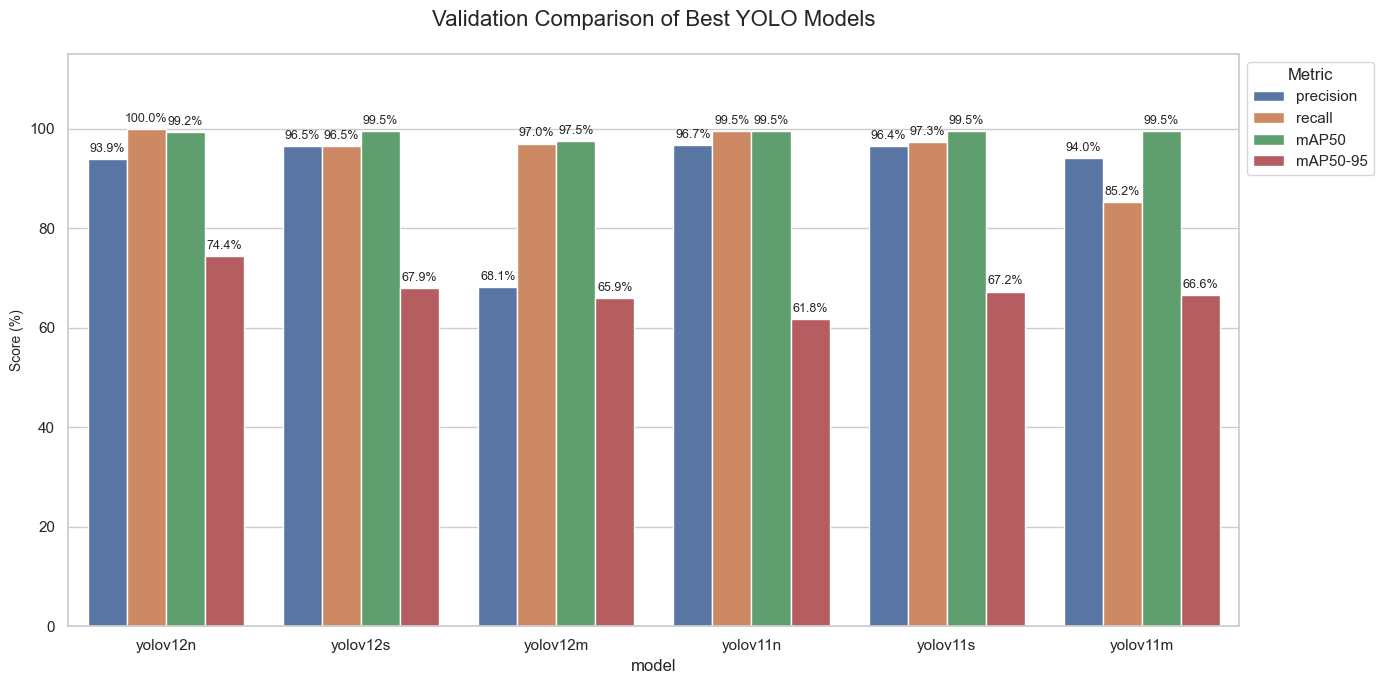

In [4]:
df_best_val = evaluate_models(BEST_MODELS)
sns.set_theme(style="whitegrid")

metrics_to_plot = ["precision", "recall", "mAP50", "mAP50-95"] # type: list[str]

# Melt the DataFrame for Seaborn plotting
df_melt = df_best_val.melt(id_vars="model", value_vars=metrics_to_plot, 
                           var_name="Metric", value_name="Value")

df_melt["Value"] = df_melt["Value"] * 100 

fig, ax = plt.subplots(figsize=(14, 7)) # type: plt.Figure, plt.Axes
sns.barplot(data=df_melt, x="model", y="Value", hue="Metric", ax=ax)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)

# English Translation: "Validation Comparison of Best YOLO Models"
ax.set_title("Validation Comparison of Best YOLO Models", fontsize=16, pad=20)
ax.set_ylabel("Score (%)", fontsize=10) 
ax.set_ylim(0, 115) 
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


## 1. Normalized Confusion Matrix
The confusion matrix illustrates the classification accuracy for each cap color. A strong diagonal line indicates high accuracy.


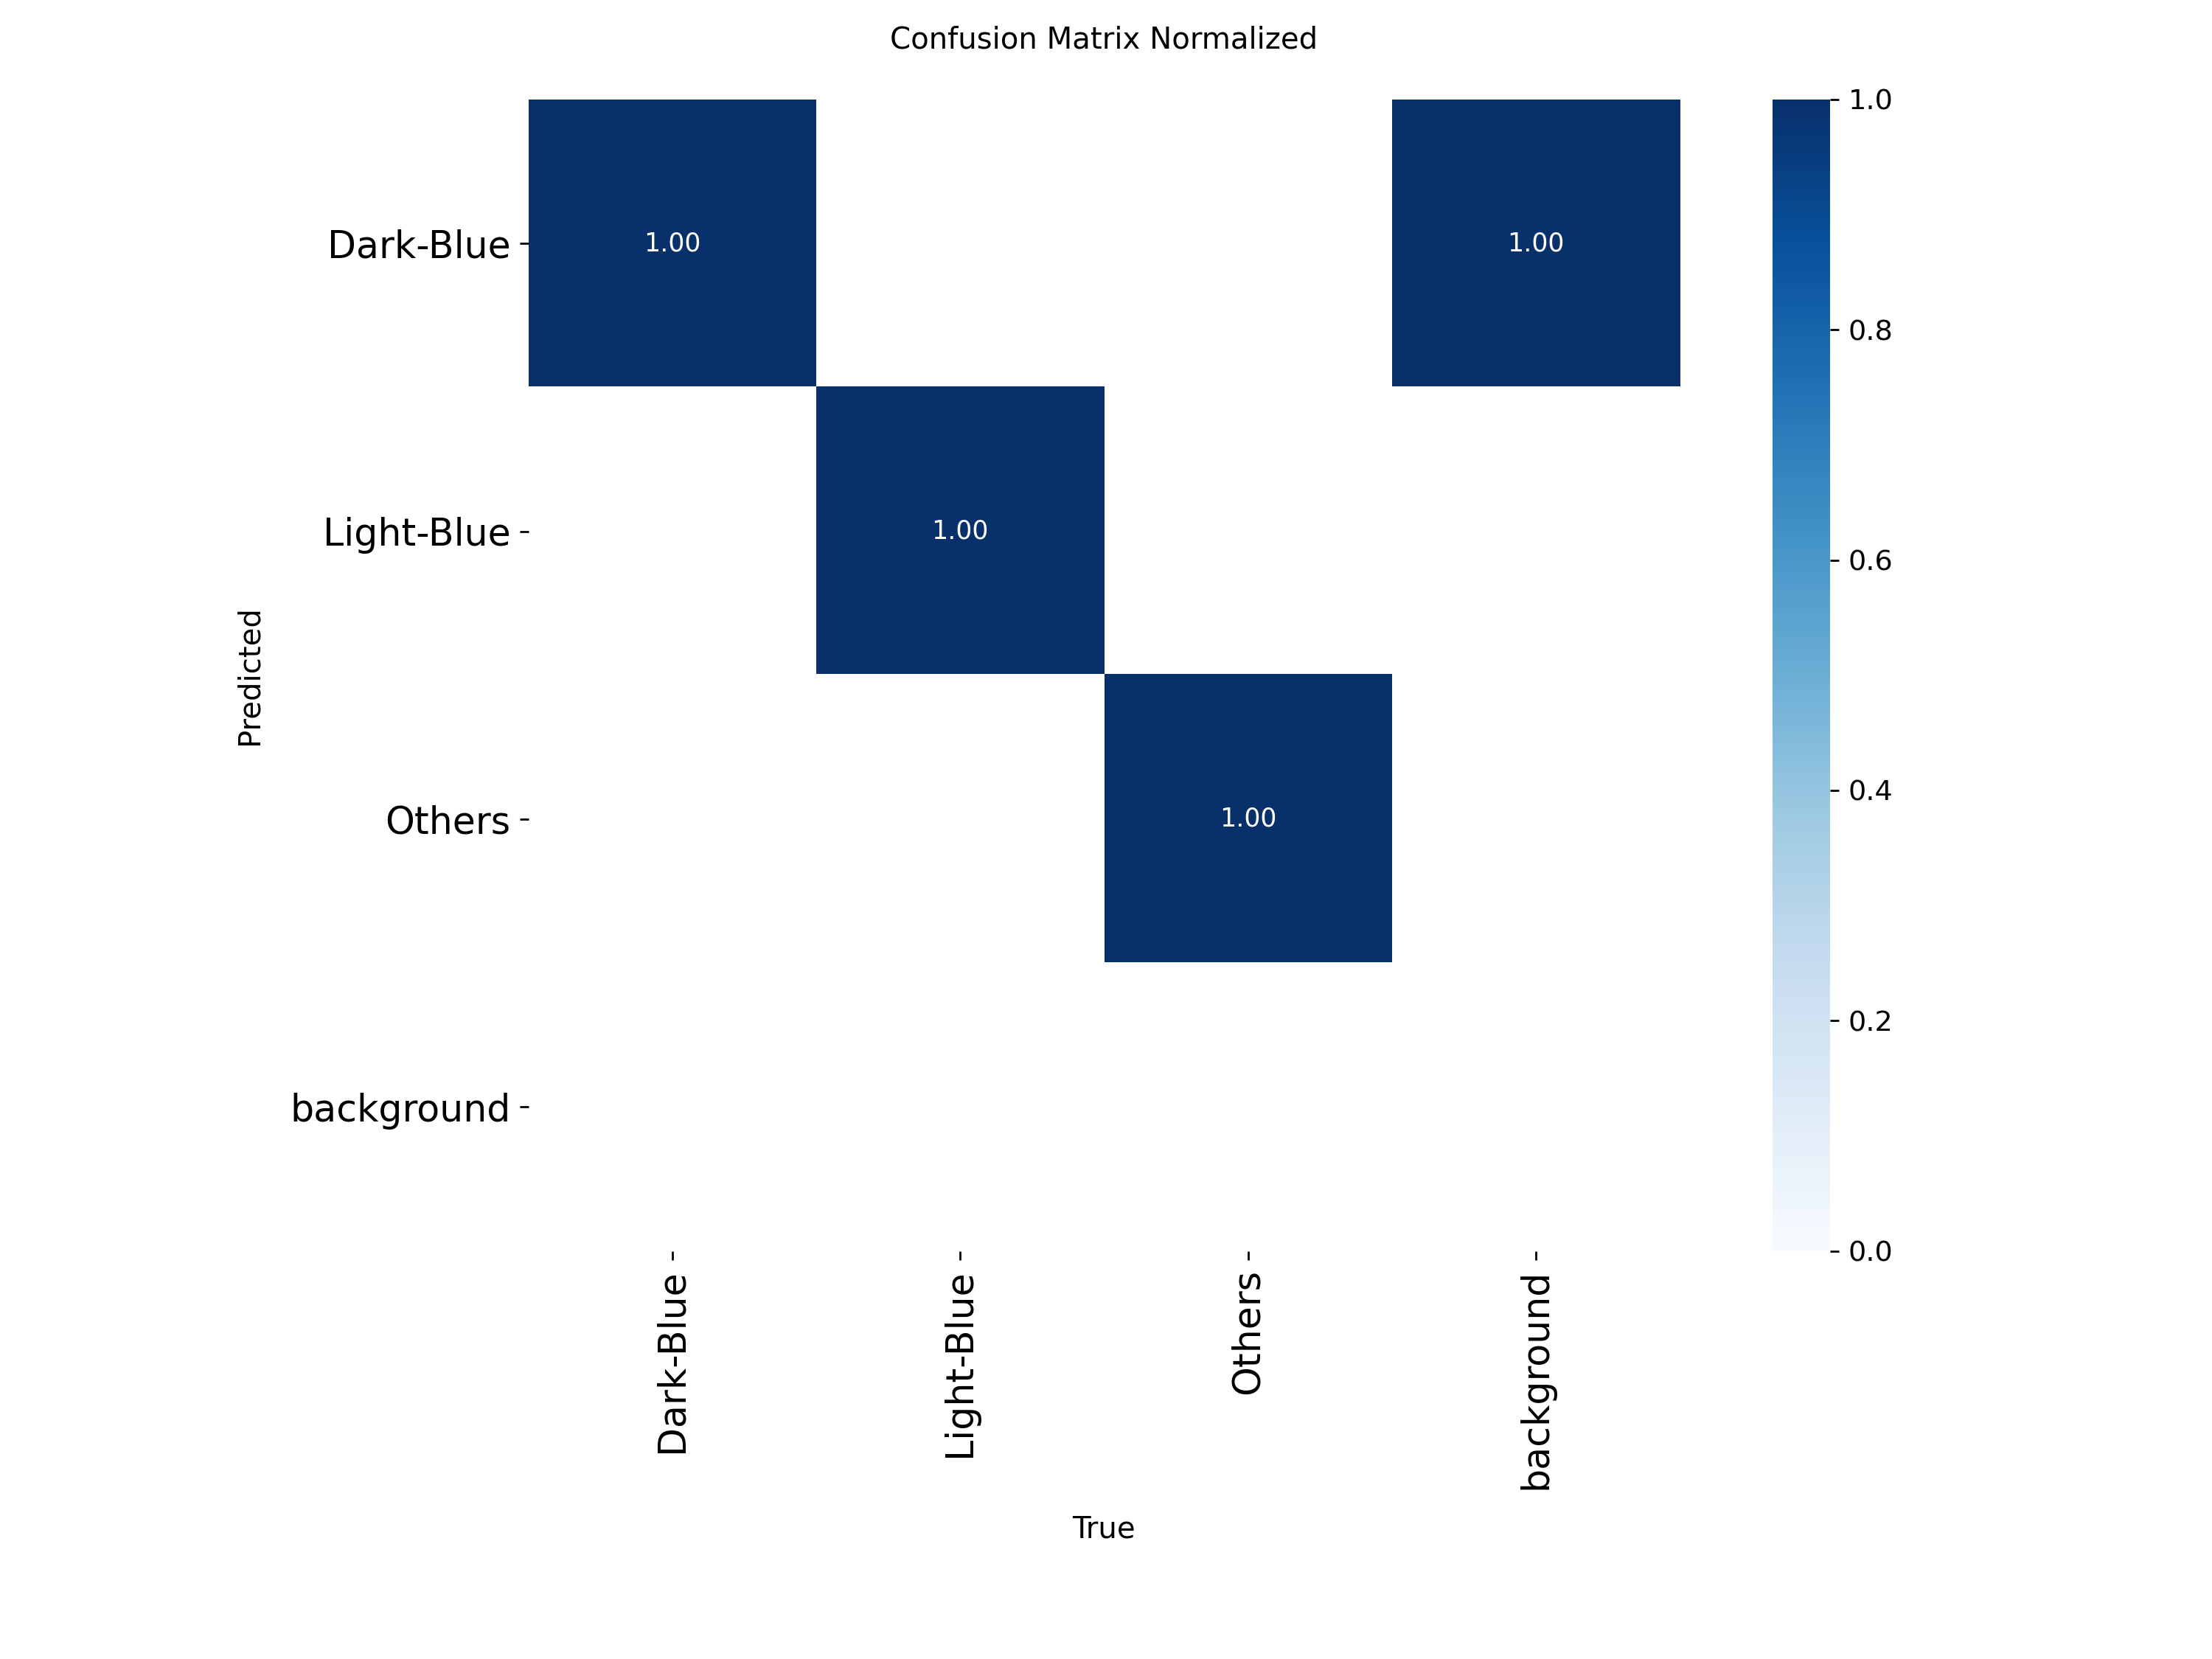


## 2. F1-Score Curve
This curve helps determine the optimal confidence threshold to balance Precision and Recall.


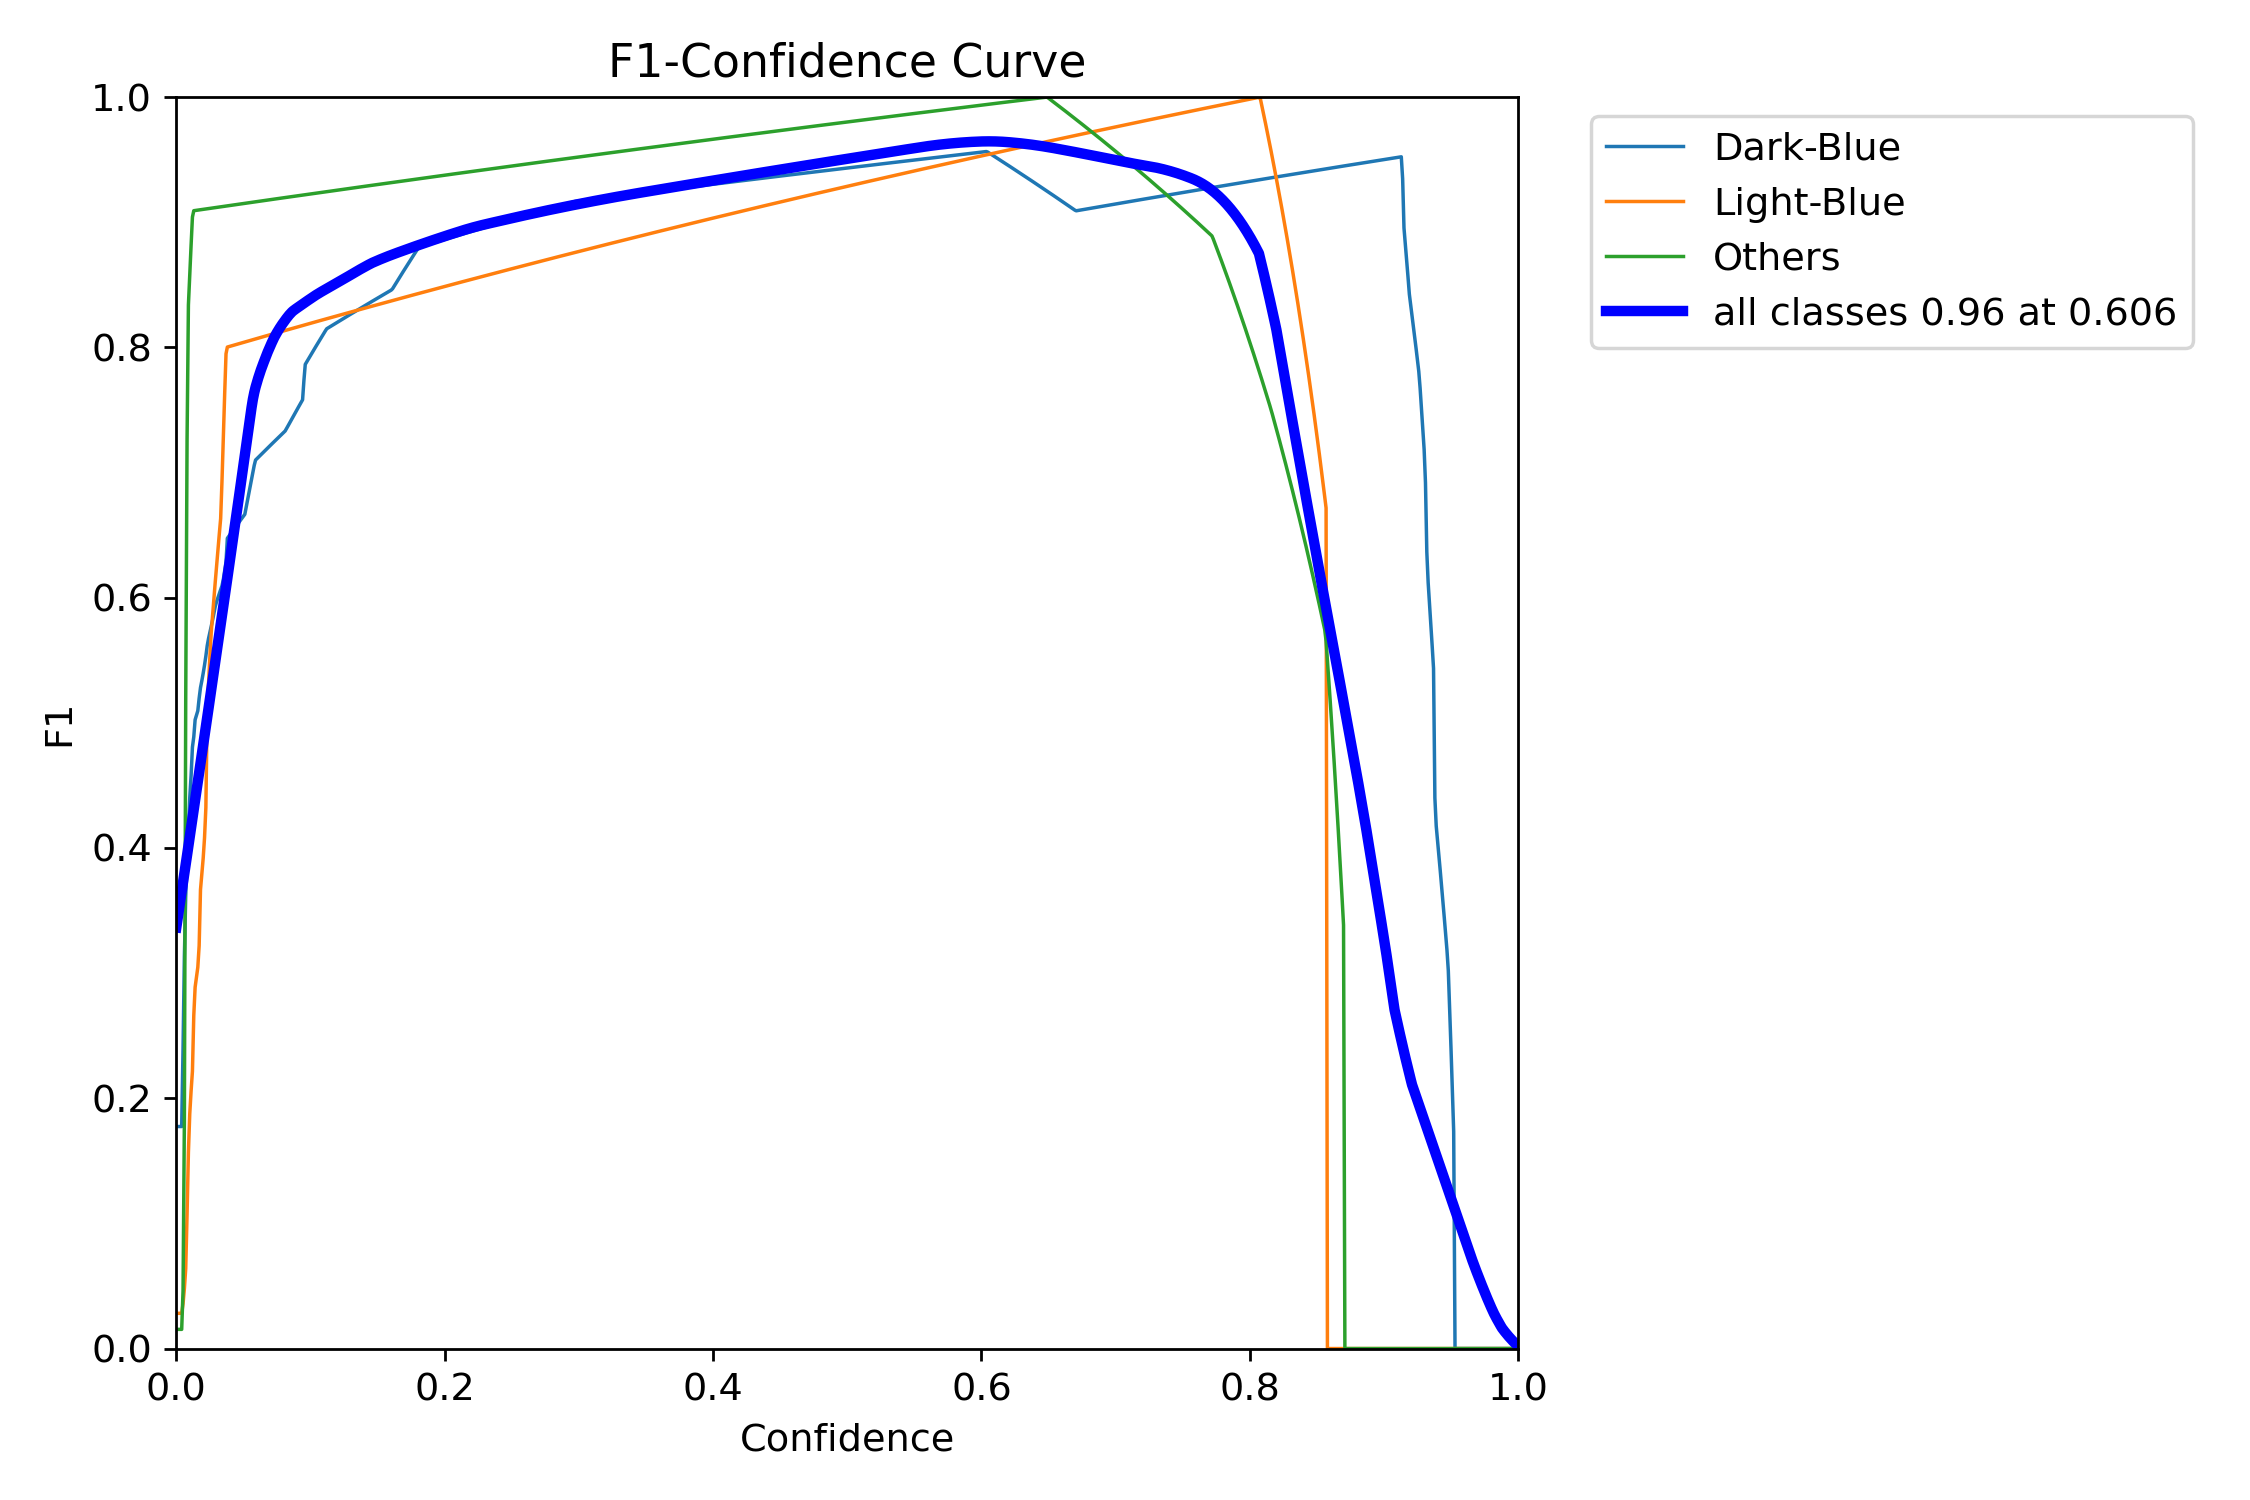


## 3. Precision-Recall Curve
The Area Under the Curve (AUC) represents the Mean Average Precision (mAP), a key metric for object detection performance.


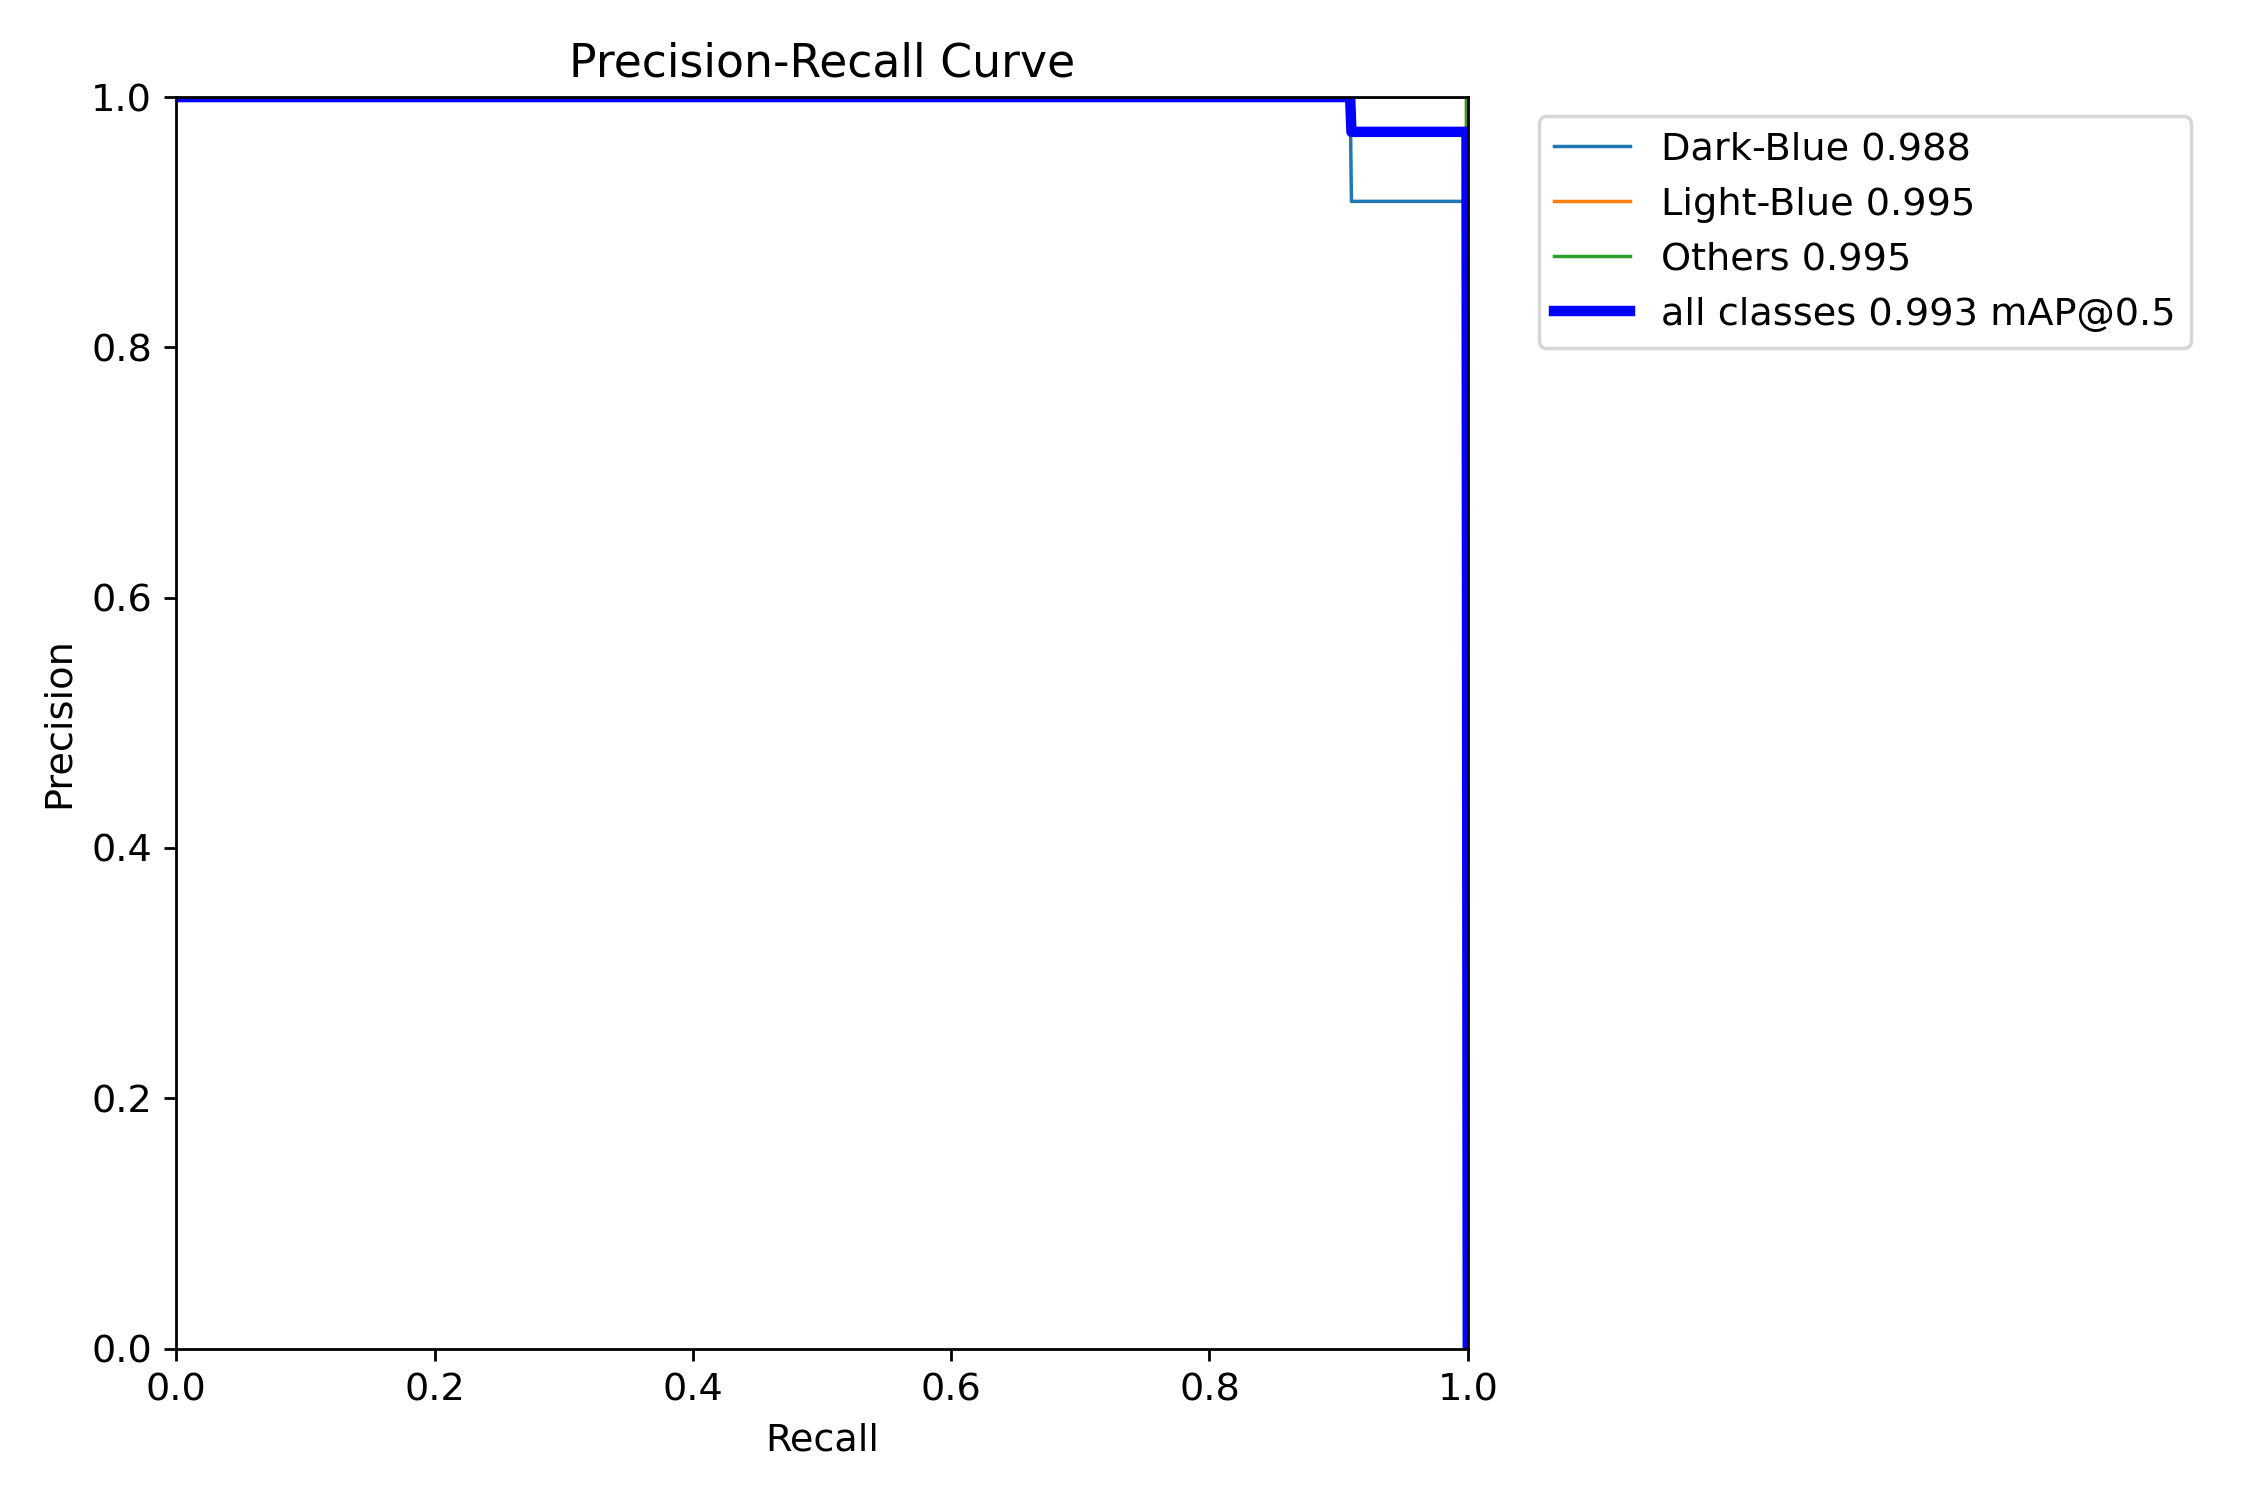


## 4. Training Losses & Metrics
Visualizing the loss convergence (train vs val) ensures the model is not overfitting.


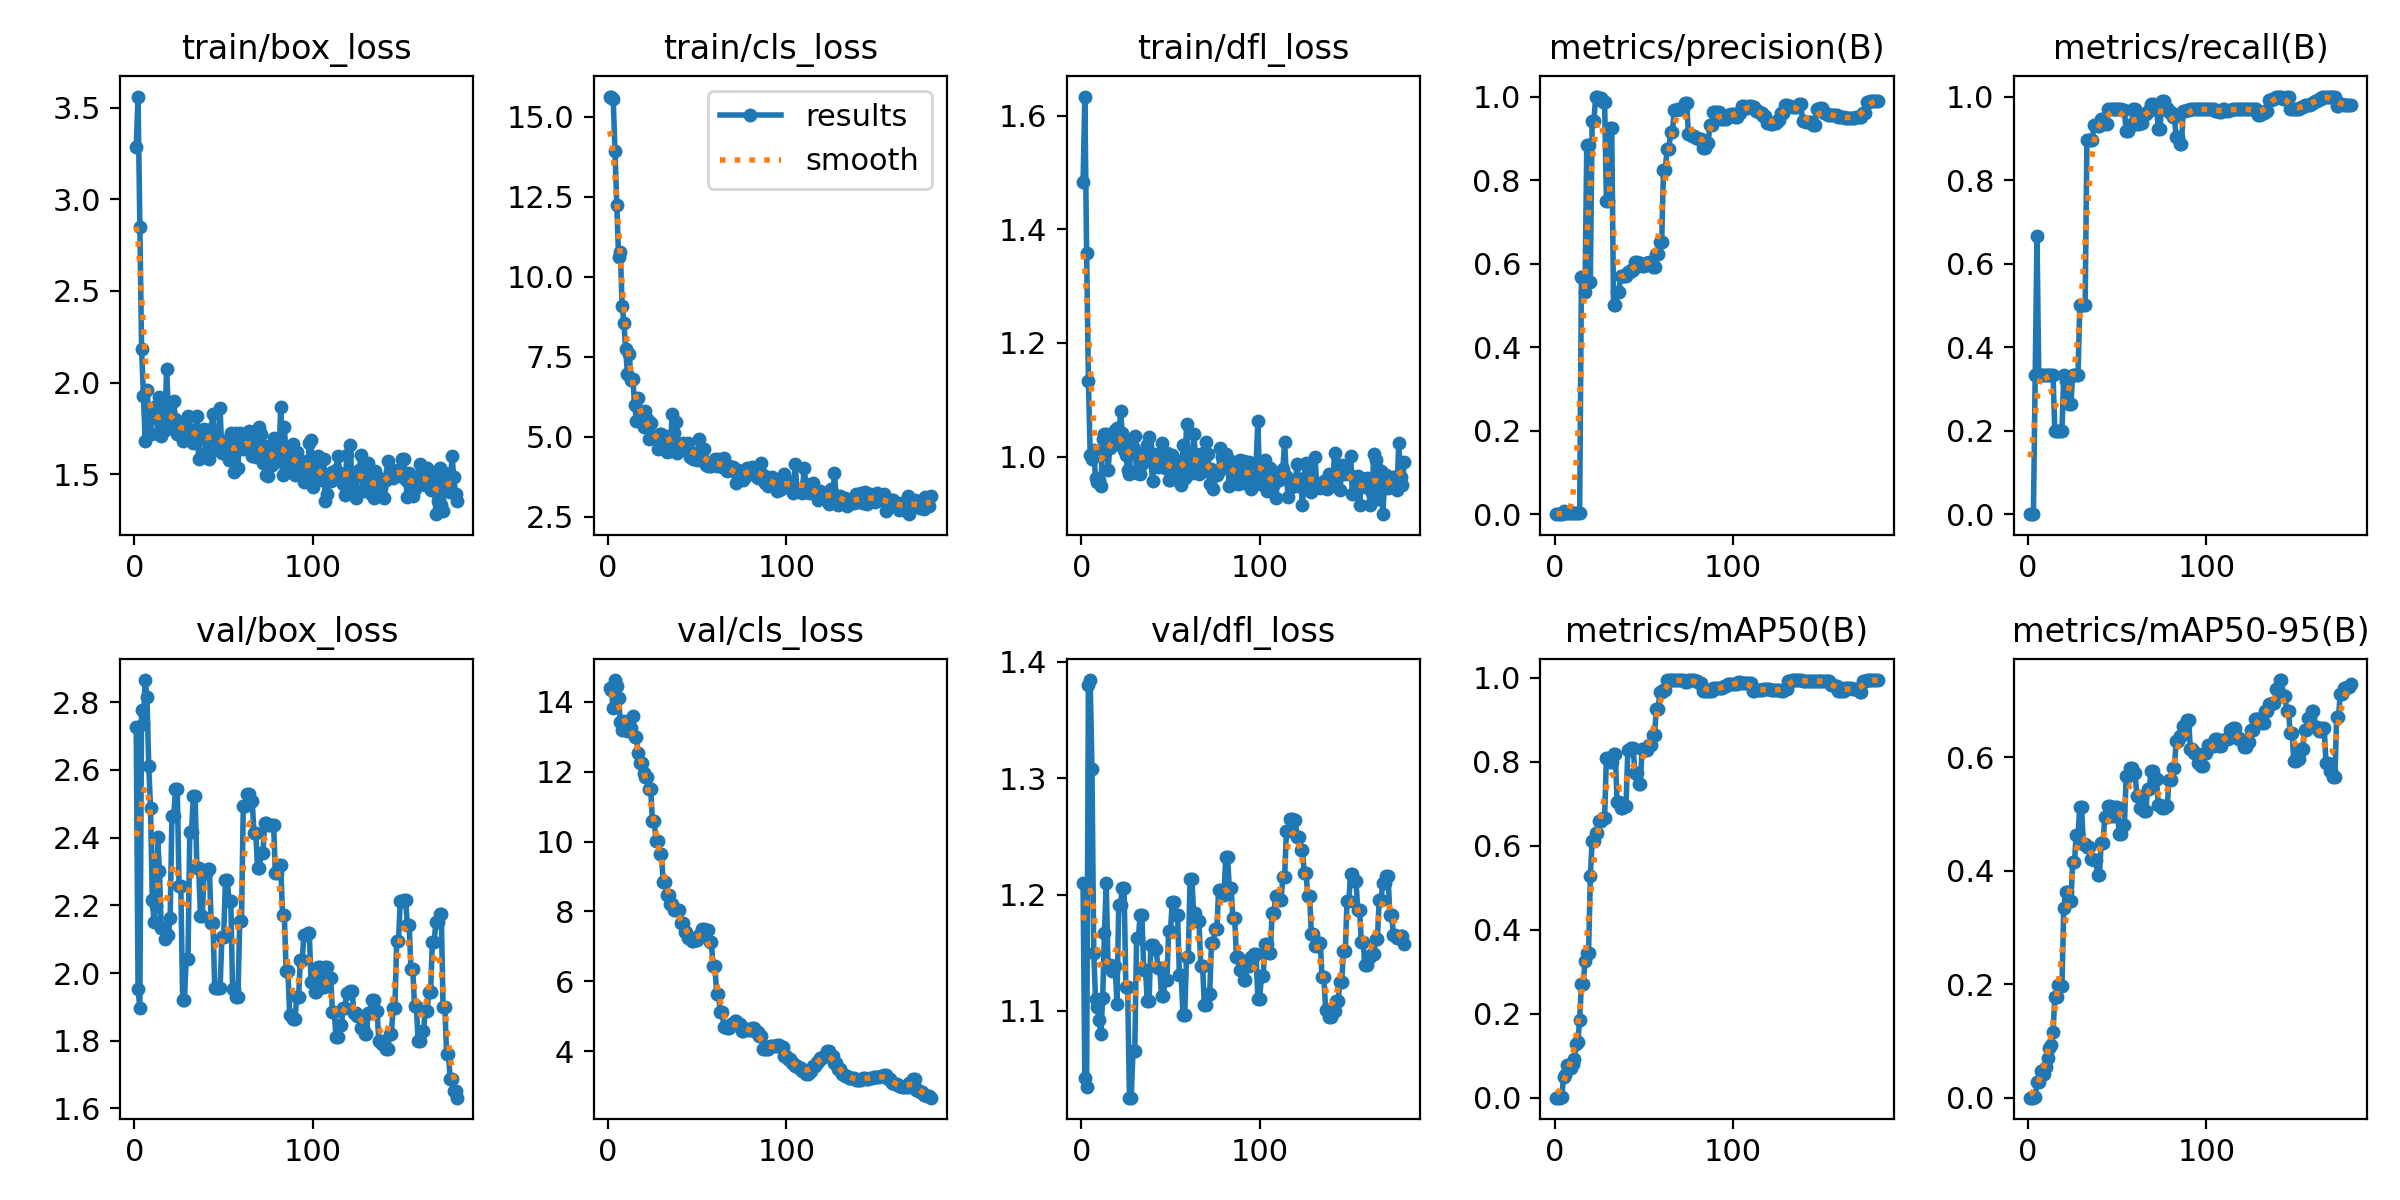


## 5. Visual Validation Predictions
Sample predictions on the validation set to visually verify detection quality.


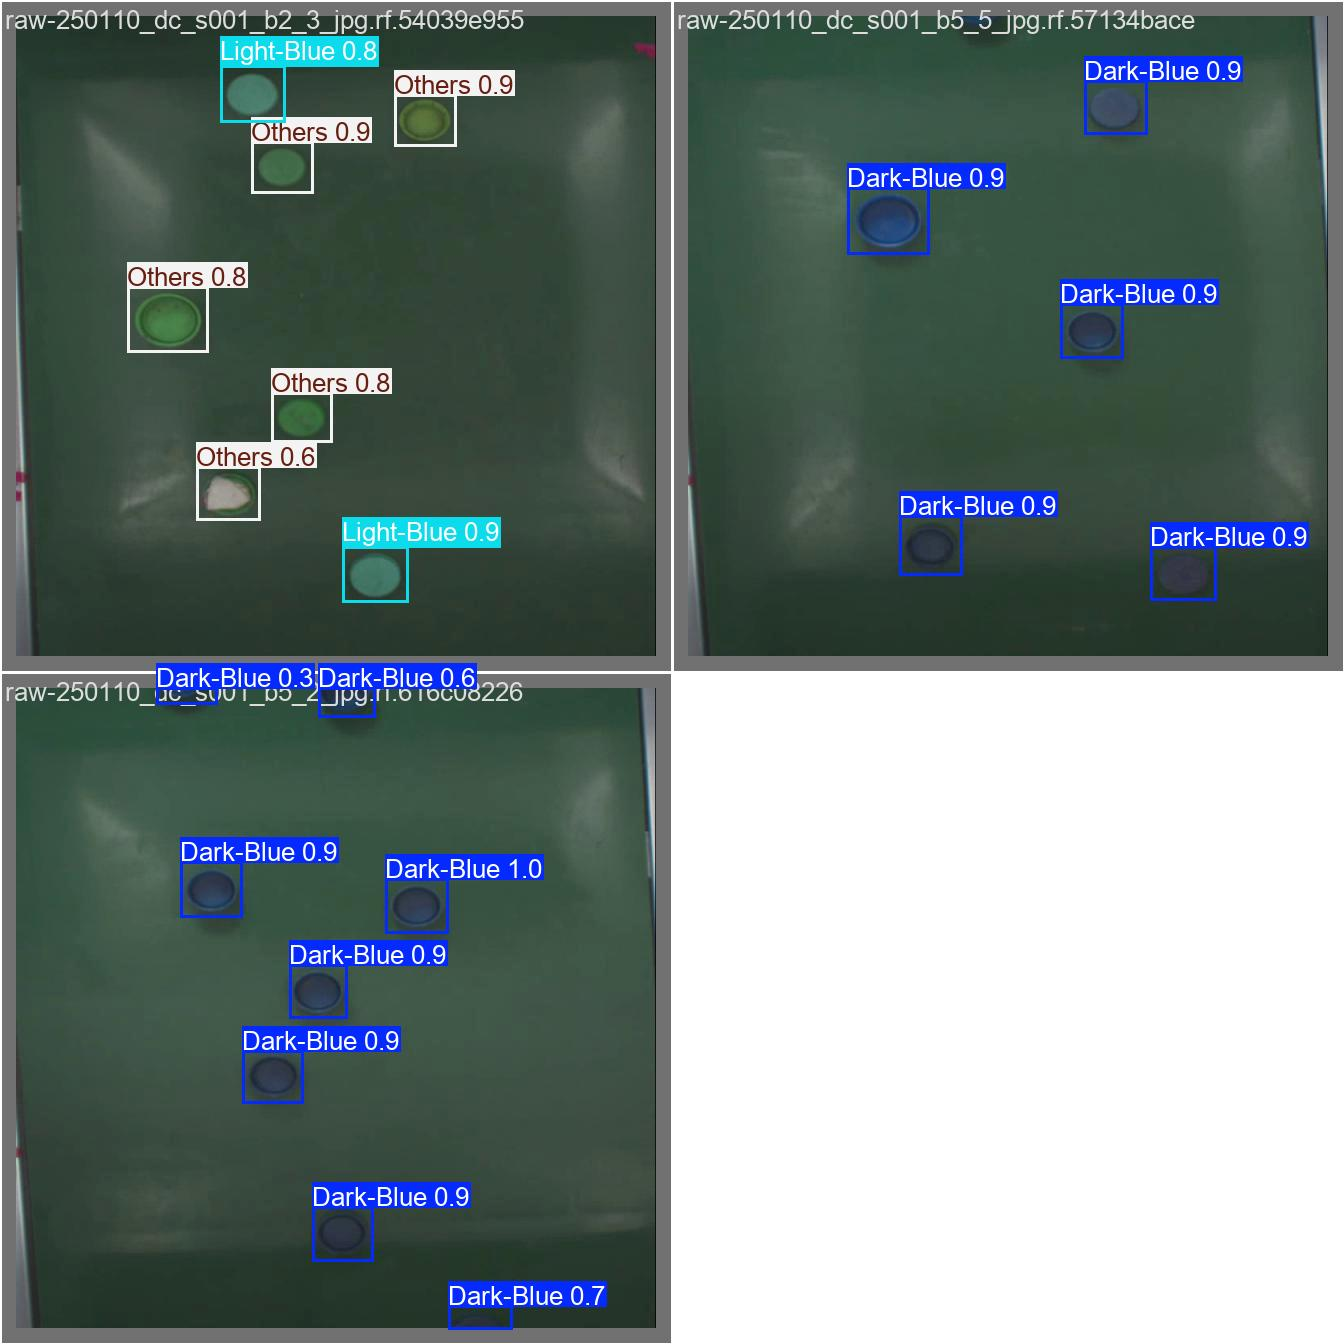

In [8]:
from IPython.display import Image, display
import os

# Define the base directory where your results are stored
# NOTE: Update this path if you move the folder. Using relative paths is recommended for GitHub.
base_path = "runs/yolov12/nano/final_v12_nano/" 

def display_analysis_image(filename: str, title: str, description: str, width: int = 600):
    """
    Helper function to display an image with a title and description.
    """
    filepath = os.path.join(base_path, filename)
    
    print(f"\n## {title}")
    print(description)
    
    if os.path.exists(filepath):
        display(Image(filename=filepath, width=width))
    else:
        print(f"Warning: File not found at {filepath}")

# 1. Confusion Matrix
display_analysis_image(
    filename="confusion_matrix_normalized.png",
    title="1. Normalized Confusion Matrix",
    description="The confusion matrix illustrates the classification accuracy for each cap color. A strong diagonal line indicates high accuracy."
)

# 2. F1-Score Curve
display_analysis_image(
    filename="BoxF1_curve.png",
    title="2. F1-Score Curve",
    description="This curve helps determine the optimal confidence threshold to balance Precision and Recall."
)

# 3. Precision-Recall Curve
display_analysis_image(
    filename="BoxPR_curve.png",
    title="3. Precision-Recall Curve",
    description="The Area Under the Curve (AUC) represents the Mean Average Precision (mAP), a key metric for object detection performance."
)

# 4. Training Results (Loss & Metrics)
display_analysis_image(
    filename="results.png", 
    title="4. Training Losses & Metrics",
    description="Visualizing the loss convergence (train vs val) ensures the model is not overfitting.",
    width=800
)

# 5. Visual Predictions
display_analysis_image(
    filename="val_batch0_pred.jpg",
    title="5. Visual Validation Predictions",
    description="Sample predictions on the validation set to visually verify detection quality.",
    width=800
)